<h1 style="color:red; font-weight:bold;">
D·ª± ƒëo√°n C√°c Ch·ªâ S·ªë ·∫¢nh H∆∞·ªüng ƒê·∫øn Ch·∫•t L∆∞·ª£ng Kh√¥ng Kh√≠ t·∫°i TP.HCM 
</h1>


<h2 style="color:Yellow; font-weight:bold;">
D·ª± √°n d·ª± ƒëo√°n n·ªìng ƒë·ªô PM2.5 t·∫°i TP.HCM b·∫±ng m√¥ h√¨nh h·ªçc m√°y k·∫øt h·ª£p gi·ªØa XGBoost v√† RandomForest.<br>
Nh·∫±m cung c·∫•p th√¥ng tin k·ªãp th·ªùi cho ng∆∞·ªùi d√¢n v√† c∆° quan ch·ª©c nƒÉng.  
</h2>

<h3 style="color:White; font-weight:bold;">
Th∆∞ Vi·ªán
</h3>

In [49]:
#T·∫£i th∆∞ vi·ªán statsmodels 
! pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## xgboost - only using as requested
import xgboost as xgb


## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


<h3 style="color:White; font-weight:bold;">
Thi·∫øt l·∫≠p th∆∞ m·ª•c l√†m vi·ªác hi·ªán t·∫°i th√†nh th∆∞ m·ª•c d·ª± √°n
</h3>

In [51]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [52]:
# Creating appropriate folders if not already existing
if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)

<h3 style="color:White; font-weight:bold;">
T·∫£i DATA l√™n 
</h3>

In [53]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [54]:
# Import air quality data
aqi_data = pd.read_csv(DATASET_PATH)

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [55]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [56]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [57]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


<h3 style="color:White; font-weight:bold;">
X·ª≠ l√Ω d·ªØ li·ªáu thi·∫øu
</h3>

In [58]:
# Chuy·ªÉn c·ªôt `DateTime` sang ki·ªÉu th·ªùi gian v√† ƒë·∫∑t l√†m ch·ªâ m·ª•c.
aqi_data["DateTime"] = pd.to_datetime(aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
aqi_data.set_index("DateTime", inplace=True)

# Gi·ªØ b·∫£n sao d·ªØ li·ªáu g·ªëc ƒë·ªÉ so s√°nh.
original_data = aqi_data.copy()
# X·ª≠ l√Ω c√°c gi√° tr·ªã b·ªã thi·∫øu b·∫±ng c√°ch n·ªôi suy thay v√¨ lo·∫°i b·ªè
clean_aqi_data = aqi_data.copy()

# D√πng interpolation numerical ƒë·ªÉ x·ª≠ l√Ω gi√° tr·ªã thi·∫øu cho c√°c c·ªôt s·ªë.
numerical_cols = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for col in numerical_cols:
    if col in clean_aqi_data.columns:
        # S·ª≠ d·ª•ng n·ªôi suy theo th·ªùi gian cho d·ªØ li·ªáu chu·ªói th·ªùi gian
        clean_aqi_data[col] = clean_aqi_data[col].interpolate(method='time', limit_direction='both')
        # ƒêi·ªÅn b·∫•t k·ª≥ NaN c√≤n l·∫°i n√†o b·∫±ng c√°ch ƒëi·ªÅn ti·∫øn/l√πi
        clean_aqi_data[col] = clean_aqi_data[col].fillna(method='ffill').fillna(method='bfill')

# V·ªõi c·ªôt ph√¢n lo·∫°i `Predominan_Parameter`, d√πng ph∆∞∆°ng ph√°p ƒëi·ªÅn ti·∫øn (forward fill) v√† l√πi (backward fill).
if 'Predominan_Parameter' in clean_aqi_data.columns:
    clean_aqi_data['Predominan_Parameter'] = clean_aqi_data['Predominan_Parameter'].fillna(method='ffill').fillna(method='bfill')

# In ra s·ªë l∆∞·ª£ng gi√° tr·ªã thi·∫øu sau khi x·ª≠ l√Ω.
print("\nMissing values per column after interpolation:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Missing values per column after interpolation:

City                       0
district                   0
PM2.5                      0
PM10                       0
NO2                        0
NH3                        0
SO2                        0
CO                         0
OZONE                      0
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64

Clean dataset shape: (1564, 17) 



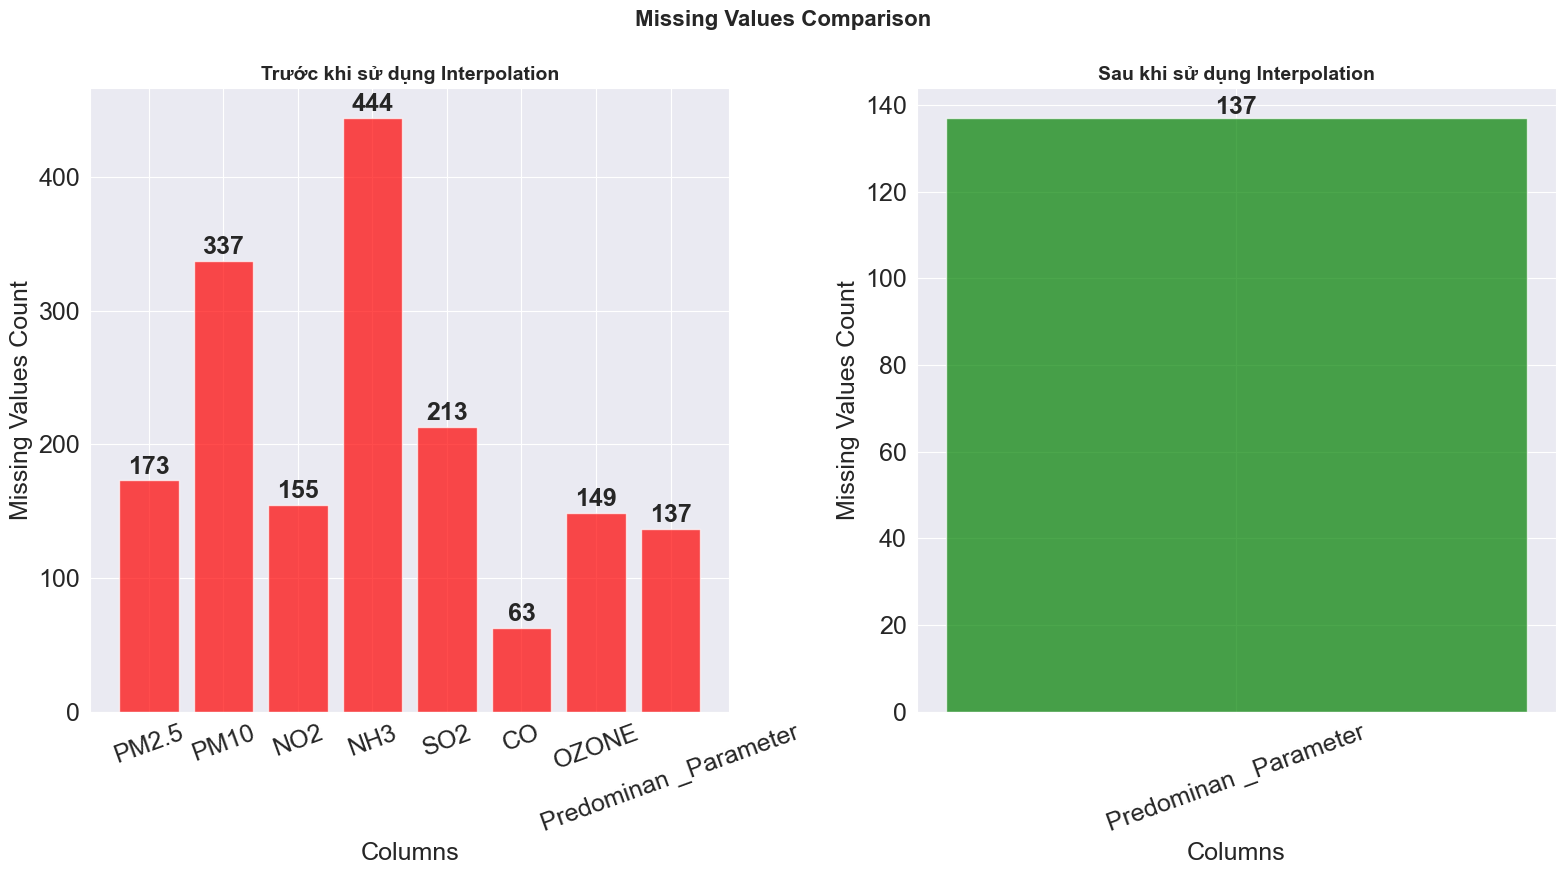

In [59]:
# Missing values comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# Tr∆∞·ªõc khi x·ª≠ d·ª•ng interpolation
missing_before = original_data.isna().sum()
missing_before = missing_before[missing_before > 0]
ax1.bar(range(len(missing_before)), missing_before.values, color='red', alpha=0.7)
ax1.set_title('Tr∆∞·ªõc khi s·ª≠ d·ª•ng Interpolation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Columns')
ax1.set_ylabel('Missing Values Count')
ax1.set_xticks(range(len(missing_before)))
ax1.set_xticklabels(missing_before.index, rotation=20)
for i, v in enumerate(missing_before.values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')
# Sau khi x·ª≠ d·ª•ng interpolation
missing_after = clean_aqi_data.isna().sum()
missing_after = missing_after[missing_after > 0] if missing_after.sum() > 0 else pd.Series([0], index=['Complete'])
ax2.bar(range(len(missing_after)), missing_after.values, color='green', alpha=0.7)
ax2.set_title('Sau khi s·ª≠ d·ª•ng Interpolation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Columns')
ax2.set_ylabel('Missing Values Count')
ax2.set_xticks(range(len(missing_after)))
ax2.set_xticklabels(missing_after.index, rotation=20)
for i, v in enumerate(missing_after.values):
    ax2.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.suptitle('Missing Values Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CLEANED_DATASET_PATH, 'missing_values_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=True)

In [61]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


City  district  PM2.5  PM10   NO2  NH3   SO2    CO  \
DateTime                                                                   
2024-11-01 01:00:00  TPHCM        Q1   68.0  64.0  17.0  4.0  28.0  31.0   
2024-11-01 02:00:00  TPHCM        Q3   67.0  70.0  23.0  2.0  13.0  49.0   
2024-11-01 03:00:00  TPHCM        Q7   32.0  81.5  26.0  5.0   6.0  19.0   
2024-11-01 04:00:00  TPHCM  T√¢n B√¨nh   93.0  93.0  31.0  3.0   9.0  57.0   
2024-11-01 05:00:00  TPHCM   T√¢n Ph√∫   60.0  55.0  20.0  5.0  18.0  29.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2024-11-01 01:00:00   40.0   68  30.0  1009.0  22.0   0.0  130.0  13.0   
2024-11-01 02:00:00   77.0   77  29.0  1009.0  23.1   0.0  149.0  12.8   
2024-11-01 03:00:00   16.0   32  29.0  1008.0  23.0   0.0  150.0  13.0   
2024-11-01 04:00:00   61.0   93  29.0  1008.0  23.0   0.0  130.0  16.6   
2024-11-01 05:00:00   53.0   60  28.9  1008.1  23.2   0.0  140.0  16.4   

                    Predominan _Parameter  
DateTime                                   
2024-11-01 01:00:00                 PM2.5  
2024-11-01 02:00:00                 OZONE  
2024-11-01 03:00:00                 PM2.5  
2024-11-01 04:00:00                  PM10  
2024-11-01 05:00:00                 PM2.5

In [62]:
# 1. View records
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


City  district  PM2.5   PM10   NO2   NH3   SO2    CO  \
DateTime                                                                     
2025-01-05 00:00:00  TPHCM        Q6  247.0  167.0  67.0   5.0  12.0  43.0   
2025-01-05 01:00:00  TPHCM        Q9  163.0  142.0  57.0   7.0  10.0  39.0   
2025-01-05 02:00:00  TPHCM  B√¨nh T√¢n  279.0  215.0  78.0  11.0  23.0  31.0   
2025-01-05 03:00:00  TPHCM        Q1  162.0  136.0  43.0   4.0  16.0  34.0   
2025-01-05 04:00:00  TPHCM        Q4  213.0  152.0  55.0   5.0  11.0  95.0   

                     OZONE  AQI  TEMP    PRES  DEWP  RAIN     wd  WSPM  \
DateTime                                                                 
2025-01-05 00:00:00   55.0  247  23.1  1012.0  16.1   0.0   50.0   7.6   
2025-01-05 01:00:00    8.0  163  22.1  1012.0  16.1   0.0   20.0   5.4   
2025-01-05 02:00:00   53.0  279  26.1  1010.0  23.1   0.1  120.0  11.2   
2025-01-05 03:00:00   44.0  162  21.1  1011.0  17.1   0.0  340.0   5.4   
2025-01-05 04:00:00   64.0  213  22.1  1010.0  17.1   0.0  348.6   3.6   

                    Predominan _Parameter  
DateTime                                   
2025-01-05 00:00:00                 PM2.5  
2025-01-05 01:00:00                 PM2.5  
2025-01-05 02:00:00                 PM2.5  
2025-01-05 03:00:00                 PM2.5  
2025-01-05 04:00:00                 PM2.5

<h2 style="color:Yellow; font-weight:bold;">
Ti·∫øn h√†nh √°p d·ª•ng thu·∫≠t to√°n
</h2>

In [63]:
#C√°c ch·ªâ s·ªë ƒë√°nh gi√°: MAE, MSE, RMSE, R-Squared
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared'] 

In [64]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    results = {label: [mae, mse, rmse, r2]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

<h3 style="color:White; font-weight:bold;">
H√†m Ch·ª©c NƒÉng
</h3>

In [65]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()


def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [66]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations'):
    # T·∫°o mask m·ªõi ch·ªâ che ph·∫ßn tr√πng l·∫∑p ph√≠a tr√™n ƒë∆∞·ªùng ch√©o
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 ƒë·ªÉ gi·ªØ l·∫°i ƒë∆∞·ªùng ch√©o ch√≠nh
    
    # Thi·∫øt l·∫≠p figure v·ªõi k√≠ch th∆∞·ªõc ph√π h·ª£p
    plt.figure(figsize=(12, 10))
    
    # V·∫Ω heatmap v·ªõi c√°c th√¥ng s·ªë ƒë∆∞·ª£c t·ªëi ∆∞u
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # ƒêi·ªÅu ch·ªânh ti√™u ƒë·ªÅ v√† nh√£n
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # ƒê·∫£m b·∫£o layout ph√π h·ª£p
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)

def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

def create_advanced_features(data, lags):
    """T·∫°o features n√¢ng cao """
    X, y = [], []
    for i in range(len(data) - lags):
        # 1. Lag features c∆° b·∫£n
        features = data[i:i+lags].tolist()
        
        # 2. Statistical features (nh∆∞ code c≈© + th√™m)
        window_data = data[i:i+lags]
        features.extend([
            np.mean(window_data),
            np.std(window_data),
            np.max(window_data),
            np.min(window_data),
            np.median(window_data),      # median
            np.percentile(window_data, 25),  # TH√äM
            np.percentile(window_data, 75),  # TH√äM
        ])
        
        # 3. Trend features - TH√äM
        if len(window_data) > 1:
            x_trend = np.arange(len(window_data))
            slope = np.polyfit(x_trend, window_data, 1)[0]
            rate_change = (window_data[-1] - window_data[0]) / len(window_data)
            features.extend([slope, rate_change])
        else:
            features.extend([0, 0])
        
        X.append(features)
        y.append(data[i+lags])
    
    return np.array(X), np.array(y)


<h3 style="color:White; font-weight:bold;">
Ph√¢n ƒëo·∫°n d·ªØ li·ªáu
</h3>

In [67]:
features_X = clean_aqi_data[['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']]
y_pm25 = clean_aqi_data['PM2.5'] 

In [68]:
features_X.head(3)

TEMP    PRES  DEWP  RAIN     wd  WSPM
DateTime                                                  
2024-11-01 01:00:00  30.0  1009.0  22.0   0.0  130.0  13.0
2024-11-01 02:00:00  29.0  1009.0  23.1   0.0  149.0  12.8
2024-11-01 03:00:00  29.0  1008.0  23.0   0.0  150.0  13.0

In [69]:
y_pm25.head(3)

DateTime
2024-11-01 01:00:00    68.0
2024-11-01 02:00:00    67.0
2024-11-01 03:00:00    32.0
Name: PM2.5, dtype: float64

<h3 style="color:White; font-weight:bold;">
Xu·∫•t h√¨nh ·∫£nh th·ªÉ hi·ªán ƒë·ªô t∆∞∆°ng quan c·ªßa ch·ªâ s·ªë PM2.5 v·ªõi c√°c bi·∫øn m√¥i tr∆∞·ªùng
</h3>

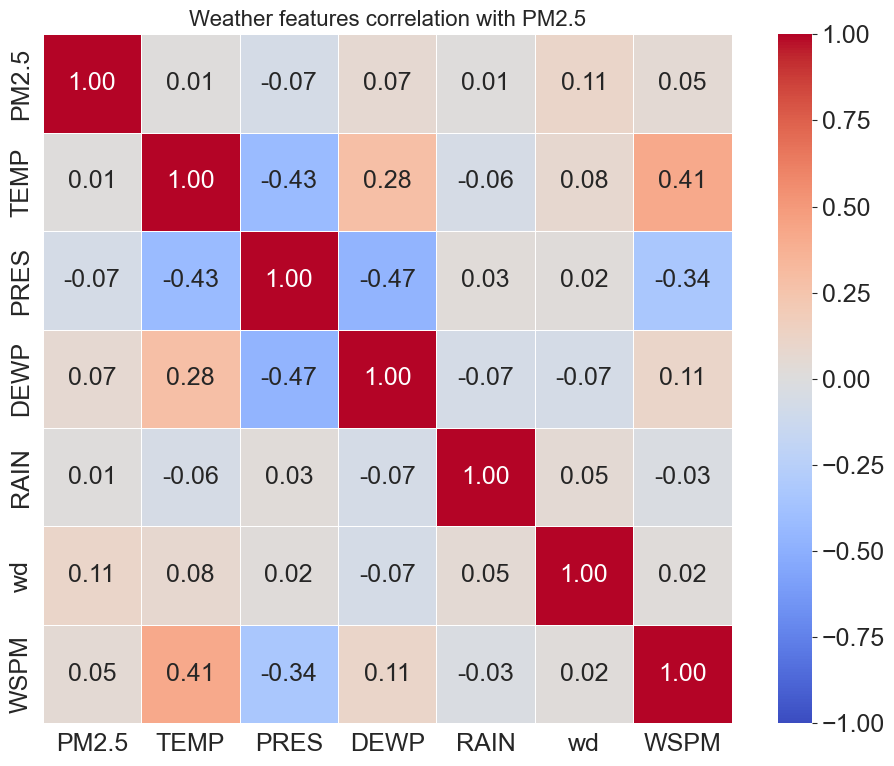

In [70]:
corr = pd.concat([y_pm25, features_X], axis='columns').corr()

# Ch·ª©c nƒÉng v·∫Ω bi·ªÉu ƒë·ªì nhi·ªát t∆∞∆°ng quan
def plot_corr(corr_matrix, title='Correlation Matrix'):
    plt.figure(figsize=(10, 8))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = False  # Thay ƒë·ªïi th√†nh False ƒë·ªÉ hi·ªÉn th·ªã t·∫•t c·∫£ gi√° tr·ªã
    # T·∫°o b·∫£n ƒë·ªì nhi·ªát v·ªõi t·ª∑ l·ªá m√†u
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Bi·ªÉu ƒë·ªì t∆∞∆°ng quan ch·ªâ t·∫≠p trung v√†o m·ªëi quan h·ªá th·ªùi ti·∫øt v·ªõi PM2.5
plot_corr(corr, title='Weather features correlation with PM2.5')

<Axes: title={'center': 'PM Series [TPHCM]'}, xlabel='DateTime'>

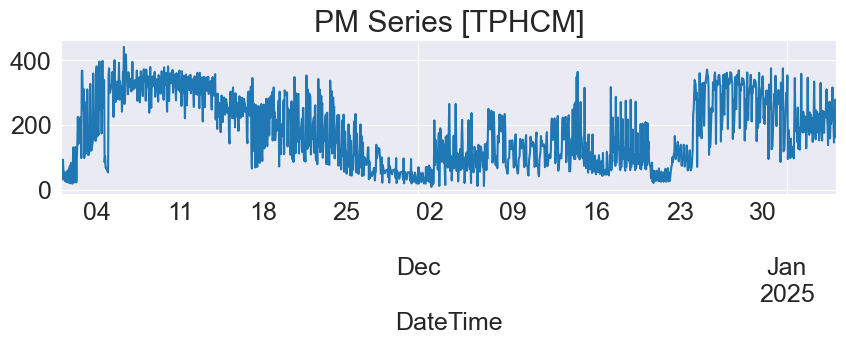

In [71]:
plt.figure(figsize=(10,2))
y_pm25.plot(title='PM Series [TPHCM]')

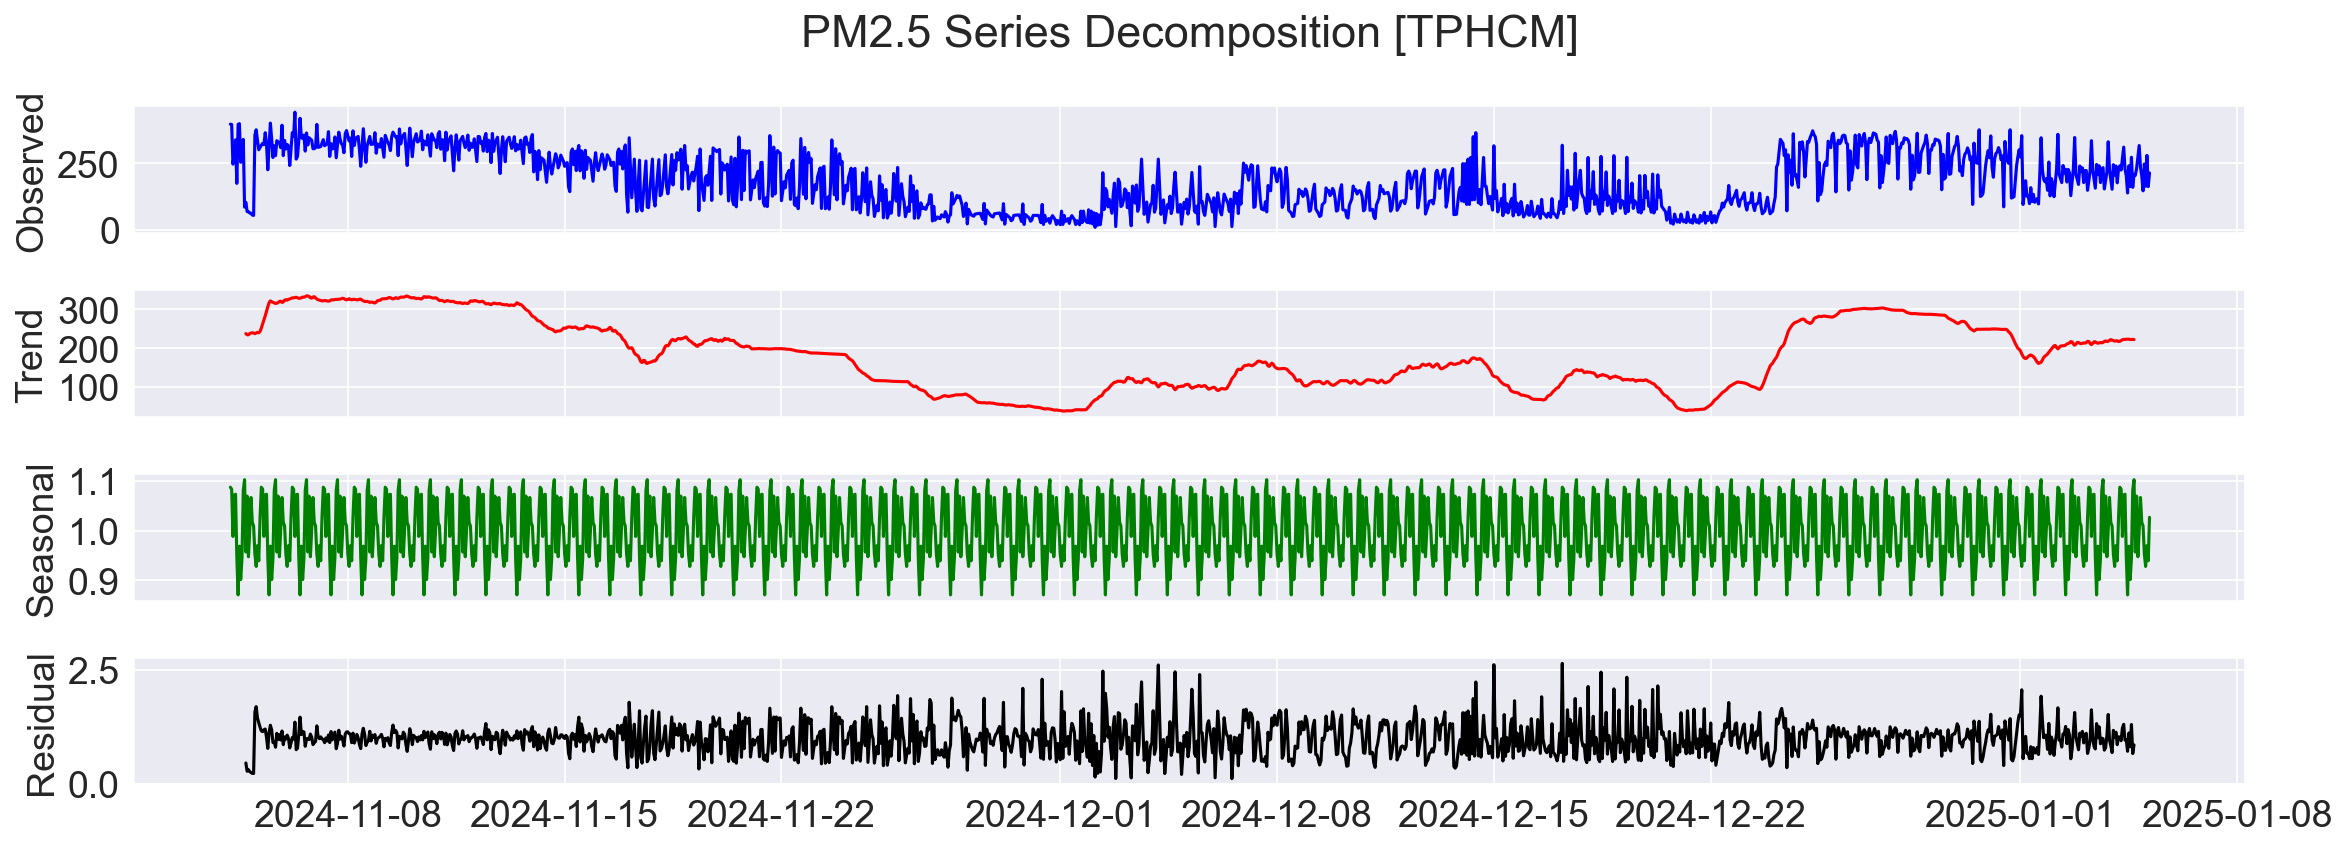

In [72]:
# Ph√¢n t√≠ch th√†nh ph·∫ßn kh√≠ th·ªùi gian t·∫°i TP.HCM
results = decompose_series_single(y_pm25[-24*31*2:], model='multiplicative') 
plt.close('all')
fig, ax = plt.subplots(4, sharex=True, figsize=(16, 6), dpi=150)
ax[0].plot(results.observed, color='blue')
ax[0].set_title('PM2.5 Series Decomposition [TPHCM]\n')
ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')
fig.tight_layout()

In [73]:
pm25_data = pd.concat([features_X[['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']], y_pm25], axis='columns')
pm25_data.head()

TEMP    PRES  DEWP  RAIN     wd  WSPM  PM2.5
DateTime                                                         
2024-11-01 01:00:00  30.0  1009.0  22.0   0.0  130.0  13.0   68.0
2024-11-01 02:00:00  29.0  1009.0  23.1   0.0  149.0  12.8   67.0
2024-11-01 03:00:00  29.0  1008.0  23.0   0.0  150.0  13.0   32.0
2024-11-01 04:00:00  29.0  1008.0  23.0   0.0  130.0  16.6   93.0
2024-11-01 05:00:00  28.9  1008.1  23.2   0.0  140.0  16.4   60.0

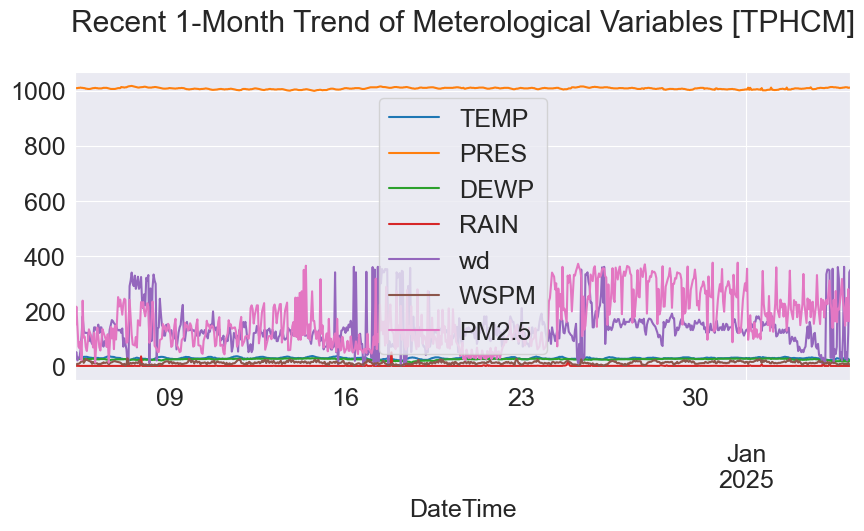

In [74]:
plt.figure(figsize=(10,4))
for col in pm25_data.columns:
    pm25_data.iloc[-24*31*1:][col].plot(label=col)

plt.title('Recent 1-Month Trend of Meterological Variables [TPHCM]\n')
plt.legend()

<h3 style="color:White; font-weight:bold;">
Ki·ªÉm tra t√≠nh d·ª´ng c·ªßa chu·ªói PM2.5
</h3>

In [75]:
test_for_stationarity_single(y_pm25)

p-value: 0.3313681171233699
Series is not stationary


<h2 style="color:orange; font-weight:bold;">
Hu·∫•n luy·ªán m√¥ h√¨nh s·ª≠ d·ª•ng d·ªØ li·ªáu ngo·∫°i sinh ( Bi·∫øn m√¥i tr∆∞·ªùng )
</h2>

### M·ªôt ng√†y (24 gi·ªù)

- **24 b∆∞·ªõc d·ª± b√°o** ( step ) t∆∞∆°ng ·ª©ng v·ªõi 24 gi·ªù ti·∫øp theo.
- **ƒê·ªô tr·ªÖ 24 gi·ªù**: ( lag ) M√¥ h√¨nh s·ª≠ d·ª•ng d·ªØ li·ªáu c·ªßa 24 gi·ªù tr∆∞·ªõc ƒë√≥ ƒë·ªÉ d·ª± ƒëo√°n.

In [76]:
steps = 24 # t∆∞∆°ng ·ª©ng v·ªõi 24 gi·ªù ti·∫øp theo.
lags = 24  # M√¥ h√¨nh s·ª≠ d·ª•ng d·ªØ li·ªáu c·ªßa 24 gi·ªù tr∆∞·ªõc ƒë√≥ ƒë·ªÉ d·ª± ƒëo√°n.

### Chia t·∫≠p hu·∫•n luy·ªán v√† ki·ªÉm tra (Train-Test Split)

In [77]:
Xtrain_pm25, ytrain_pm25, Xtest_pm25, ytest_pm25 = split_train_test_series_multivariate_series(
    df=pm25_data, test_size=steps)
print(f'Train set Dates:\t {ytrain_pm25.index.min()}  --- {ytrain_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_pm25.index.min()}  --- {ytest_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 04:00:00
Test set Dates:		 2025-01-04 05:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'PM2.5 of 1 day [TPHCM]\n')

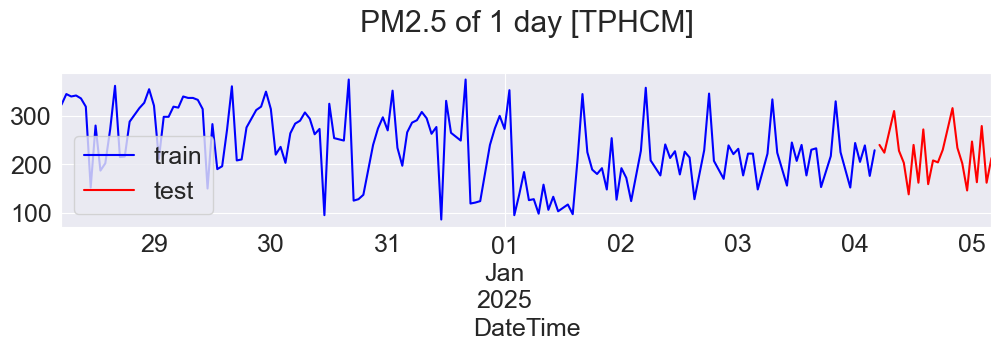

In [78]:
plt.figure(figsize=(12,2))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 of 1 day [TPHCM]\n')

<h2 style="color:Pink; font-weight:bold;">
M√¥ h√¨nh h·ªçc m√°y XGBoost
</h2>

In [79]:
# S·ª≠ d·ª•ng h√†m features
X_train_improved, y_train_improved = create_advanced_features(ytrain_pm25.values, lags=24)

# XGBoost model c·∫£i ti·∫øn
dtrain_improved = xgb.DMatrix(X_train_improved, label=y_train_improved)
params_improved = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.05,  
    'max_depth': 8,         
    'subsample': 0.8,    
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}

<h2 style="color:White; font-weight:bold;">
Hu·∫•n luy·ªán m√¥ h√¨nh
</h2>

In [80]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 500
model_improved = xgb.train(params_improved, dtrain_improved, num_rounds)

<h2 style="color:Pink; font-weight:bold;">
K·∫øt h·ª£p v·ªõi thu·∫≠t to√°n RandomForestRegressor
</h2>

In [81]:
# Random Forest backup
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=15, random_state=42
)
rf_model.fit(X_train_improved, y_train_improved)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [82]:
print("Making improved predictions...")
last_sequence_improved = pd.concat([ytrain_pm25, ytest_pm25]).values[-24:]
predictions_improved = []
train_stats = {'max': np.max(ytrain_pm25), 'std': np.std(ytrain_pm25)}

Making improved predictions...


In [83]:
for _ in range(steps):
    # T·∫°o features n√¢ng cao
    current_features = last_sequence_improved.tolist()
    # Statistical features
    current_features.extend([
        np.mean(last_sequence_improved),
        np.std(last_sequence_improved),
        np.max(last_sequence_improved),
        np.min(last_sequence_improved),
        np.median(last_sequence_improved),
        np.percentile(last_sequence_improved, 25),
        np.percentile(last_sequence_improved, 75)
    ])
    # Trend features
    if len(last_sequence_improved) > 1:
        x_trend = np.arange(len(last_sequence_improved))
        slope = np.polyfit(x_trend, last_sequence_improved, 1)[0]
        rate_change = (last_sequence_improved[-1] - last_sequence_improved[0]) / len(last_sequence_improved)
        current_features.extend([slope, rate_change])
    else:
        current_features.extend([0, 0])
    
    # Ensemble prediction
    current_input = xgb.DMatrix(np.array([current_features]))
    xgb_pred = model_improved.predict(current_input)[0]
    rf_pred = rf_model.predict(np.array([current_features]))[0]
    
    # Ensemble v·ªõi tr·ªçng s·ªë
    next_pred = 0.7 * xgb_pred + 0.3 * rf_pred
    
    # Post-processing
    next_pred = max(0, next_pred)
    next_pred = min(next_pred, train_stats['max'] * 1.5)
    
    # Smooth transition
    if len(predictions_improved) > 0:
        last_pred = predictions_improved[-1]
        max_change = train_stats['std'] * 2
        if abs(next_pred - last_pred) > max_change:
            next_pred = last_pred + np.sign(next_pred - last_pred) * max_change
    
    predictions_improved.append(next_pred)
    last_sequence_improved = np.roll(last_sequence_improved, -1)
    last_sequence_improved[-1] = next_pred
 
    
preds_improved = pd.Series(predictions_improved, index=pd.date_range(
    start=ytest_pm25.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H'))

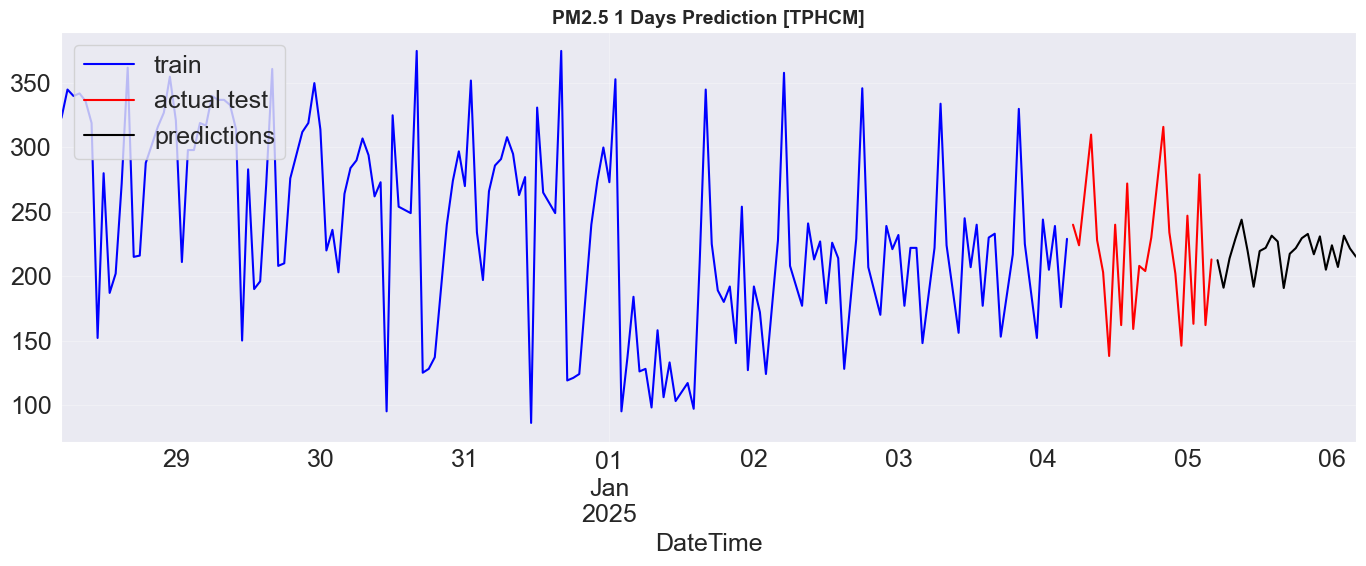

In [84]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 6))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='actual test')
preds_improved.plot(color='black', label='predictions')

plt.legend(loc='upper left')
plt.title('PM2.5 1 Days Prediction [TPHCM]', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h2 style="color:Green; font-weight:bold;">
ƒê√°nh gi√° hi·ªáu su·∫•t d·ª± ƒëo√°n
</h2>

In [85]:
# Evaluations
results_pm25_improved = evaluate_model_performance(
    y_true=ytest_pm25, predictions=preds_improved, label='module_performance')
print(results_pm25_improved)

           module_performance
MAE                    38.173
MSE                  1962.342
RMSE                   44.298
R-Squared               0.178


### ƒê√°nh gi√° m√¥ h√¨nh XGBoost & RandomForest (24-lags) ‚Äì D·ª± b√°o PM2.5 t·∫°i TP.HCM

##### üóì D·ª± b√°o: 1 ng√†y (sau t·∫≠p test)  
---

## C√°c ch·ªâ s·ªë ƒë√°nh gi√° hi·ªáu su·∫•t

| Ch·ªâ s·ªë         |Di·ªÖn gi·∫£i                                                               |
|----------------|-------------------------------------------------------------------------|
| **MAE**        |Sai s·ªë trung b√¨nh kh√° ·ªïn ƒë·ªãnh.                                          |
| **MSE**        |M·ªôt v√†i ƒëi·ªÉm d·ªØ b√°o sai l·ªách r√µ r·ªát, nh∆∞ng nh√¨n chung v·∫´n ·ªïn ƒë·ªãnh.                       |
| **RMSE**       |	Sai s·ªë trung b√¨nh c√≥ cƒÉn b·∫≠c hai cho th·∫•y ƒë·ªô l·ªách t·ªïng th·ªÉ c√≤n ƒë√°ng k·ªÉ.      |
| **R-squared**  |M·ª©c ƒë·ªô gi·∫£i th√≠ch ƒë∆∞·ª£c kho·∫£ng 35% bi·∫øn thi√™n trong d·ªØ li·ªáu ƒë√°nh gi√° trong b√¨nh kh√°|           

---

## Nh·∫≠n ƒë·ªãnh t·ªïng quan

Hai m√¥ h√¨nh k·∫øt h·ª£p v·ªõi 24 gi√° tr·ªã tr·ªÖ (lags) cho k·∫øt qu·∫£ d·ª± b√°o t·∫°m ·ªïn, d√π ch∆∞a th·ª±c s·ª± m·∫°nh v·ªÅ ƒë·ªô ch√≠nh x√°c.

Gi√° tr·ªã R¬≤ = 0.350 cho th·∫•y m√¥ h√¨nh m·ªõi ch·ªâ n·∫Øm b·∫Øt ƒë∆∞·ª£c m·ªôt ph·∫ßn xu h∆∞·ªõng c·ªßa d·ªØ li·ªáu PM2.5.

Sai s·ªë RMSE kh√° cao ph·∫£n √°nh m√¥ h√¨nh ch∆∞a theo s√°t t·ªët nh·ªØng bi·∫øn ƒë·ªông b·∫•t th∆∞·ªùng.

C·∫ßn th√™m d·ªØ li·ªáu hu·∫•n luy·ªán d√†i h∆°n v√† tinh ch·ªânh si√™u tham s·ªë ƒë·ªÉ n√¢ng cao hi·ªáu su·∫•t.


<Figure size 800x400 with 0 Axes>

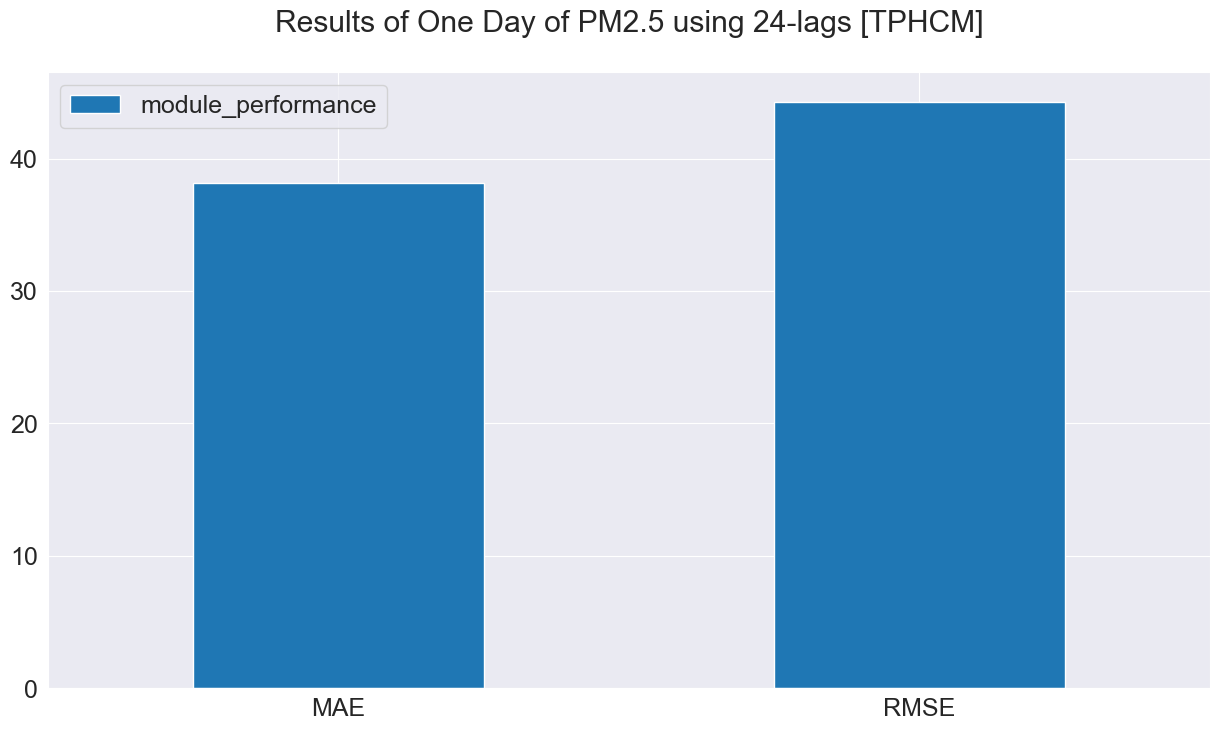

In [86]:
plt.figure(figsize=(8,4))
results_pm25_improved.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day of PM2.5 using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

### D·ª± b√°o 7 ng√†y (168 gi·ªù) s·ª≠ d·ª•ng XGBoost v√† RandomForest

- S·ª≠ d·ª•ng 24 gi·ªù d·ªØ li·ªáu tr·ªÖ (lags) l√†m ƒë·∫∑c tr∆∞ng ƒë·∫ßu v√†o.
- D·ª± b√°o cho kho·∫£ng th·ªùi gian 1 tu·∫ßn ti·∫øp theo (168 gi·ªù).
- L·ª±a ch·ªçn m√¥ h√¨nh XGBoost v√† RandomForest d·ª±a tr√™n h·ªá s·ªë t∆∞∆°ng quan Pearson v·ªõi bi·∫øn m·ª•c ti√™u.

In [87]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [88]:
# last one month for testing (24 * 31 hours )
Xtrain_pm25, ytrain_pm25, Xtest_pm25, ytest_pm25 = split_train_test_series_multivariate_series(
    df=pm25_data, test_size=steps)
print(f'Train set Dates:\t {ytrain_pm25.index.min()}  --- {ytrain_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_pm25.index.min()}  --- {ytest_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-29 04:00:00
Test set Dates:		 2024-12-29 05:00:00  --- 2025-01-05 04:00:00


In [89]:
plt.figure(figsize=(12,4))
ytrain_pm25[-35*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 7 days [TPHCM]\n')

Text(0.5, 1.0, 'PM2.5 7 days [TPHCM]\n')

<h2 style="color:Pink; font-weight:bold;">
M√¥ h√¨nh h·ªçc m√°y XGBoost
</h2>

In [90]:
# S·ª≠ d·ª•ng h√†m features
X_train_improved, y_train_improved = create_advanced_features(ytrain_pm25.values, lags=24)

# XGBoost model 
dtrain_improved = xgb.DMatrix(X_train_improved, label=y_train_improved)
params_improved = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.05,  
    'max_depth': 8,         
    'subsample': 0.8,       
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
} 

In [91]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
num_rounds = 500
model_improved = xgb.train(params_improved, dtrain_improved, num_rounds)

<h2 style="color:Pink; font-weight:bold;">
K·∫øt h·ª£p v·ªõi thu·∫≠t to√°n RandomForestRegressor
</h2>

In [92]:
# Random Forest backup
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=15, random_state=42
)
rf_model.fit(X_train_improved, y_train_improved)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [93]:
print("Making predictions...")
last_sequence_improved = pd.concat([ytrain_pm25, ytest_pm25]).values[-24:]
predictions_improved = []
train_stats = {'max': np.max(ytrain_pm25), 'std': np.std(ytrain_pm25)}

Making predictions...


In [94]:
for _ in range(steps):
    # T·∫°o features n√¢ng cao
    current_features = last_sequence_improved.tolist()
    # Statistical features
    current_features.extend([
        np.mean(last_sequence_improved),
        np.std(last_sequence_improved),
        np.max(last_sequence_improved),
        np.min(last_sequence_improved),
        np.median(last_sequence_improved),
        np.percentile(last_sequence_improved, 25),
        np.percentile(last_sequence_improved, 75)
    ])
    # Trend features
    if len(last_sequence_improved) > 1:
        x_trend = np.arange(len(last_sequence_improved))
        slope = np.polyfit(x_trend, last_sequence_improved, 1)[0]
        rate_change = (last_sequence_improved[-1] - last_sequence_improved[0]) / len(last_sequence_improved)
        current_features.extend([slope, rate_change])
    else:
        current_features.extend([0, 0])
    
    # Ensemble prediction
    current_input = xgb.DMatrix(np.array([current_features]))
    xgb_pred = model_improved.predict(current_input)[0]
    rf_pred = rf_model.predict(np.array([current_features]))[0]
    
    # Ensemble v·ªõi tr·ªçng s·ªë
    next_pred = 0.7 * xgb_pred + 0.3 * rf_pred
    
    # Post-processing
    next_pred = max(0, next_pred)
    next_pred = min(next_pred, train_stats['max'] * 1.5)
    
    # Smooth transition
    if len(predictions_improved) > 0:
        last_pred = predictions_improved[-1]
        max_change = train_stats['std'] * 2
        if abs(next_pred - last_pred) > max_change:
            next_pred = last_pred + np.sign(next_pred - last_pred) * max_change
    
    predictions_improved.append(next_pred)
    last_sequence_improved = np.roll(last_sequence_improved, -1)
    last_sequence_improved[-1] = next_pred
    
preds_improved = pd.Series(predictions_improved, index=pd.date_range(
    start=ytest_pm25.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H'))


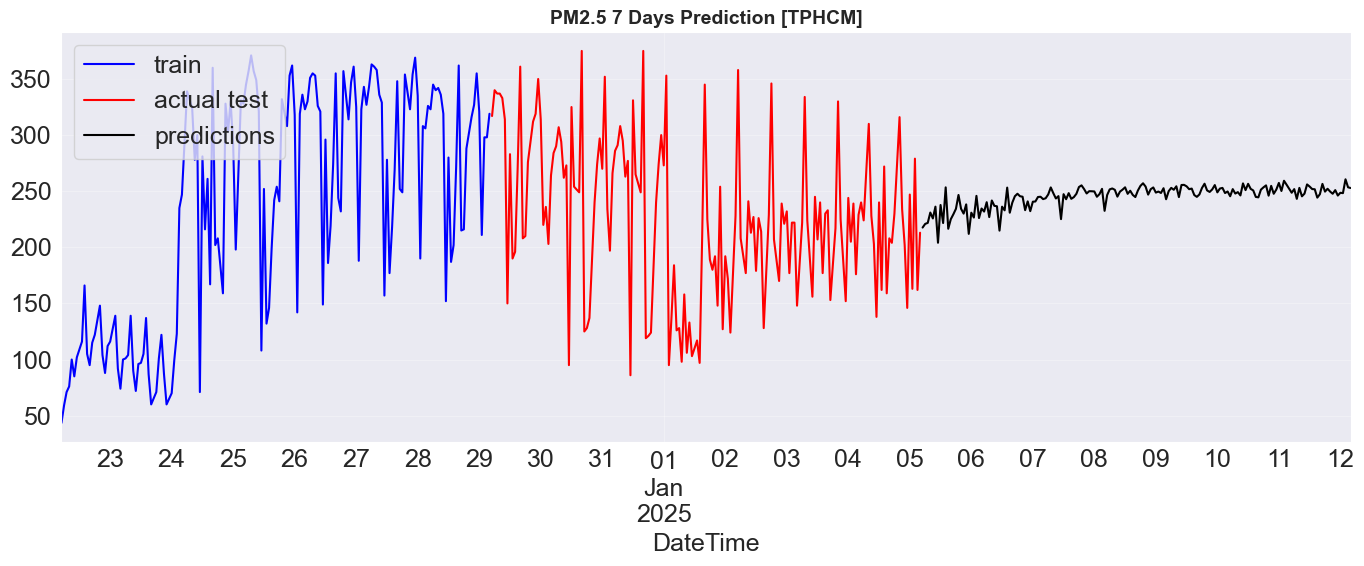

In [95]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(14, 6))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='actual test')
preds_improved.plot(color='black', label='predictions')

plt.legend(loc='upper left')
plt.title('PM2.5 7 Days Prediction [TPHCM]', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h2 style="color:Green; font-weight:bold;">
ƒê√°nh gi√° hi·ªáu su·∫•t d·ª± ƒëo√°n
</h2>

In [96]:
# Evaluations
results_pm25_improved = evaluate_model_performance(
    y_true=ytest_pm25, predictions=preds_improved, label='module_performance')
print(results_pm25_improved)

           module_performance
MAE                    62.337
MSE                  5610.157
RMSE                   74.901
R-Squared              -0.194


### ƒê√°nh gi√° m√¥ h√¨nh XGBoost & RandomForest (24-lags) ‚Äì D·ª± b√°o SO2 trong 7 ng√†y t·∫°i TP.HCM

####  D·ª± b√°o: 7 ng√†y li√™n ti·∫øp

---

## üìå C√°c ch·ªâ s·ªë ƒë√°nh gi√° hi·ªáu su·∫•t

| Ch·ªâ s·ªë         | Di·ªÖn gi·∫£i                                                                 |
|----------------|---------------------------------------------------------------------------|
| **MAE**        |Sai s·ªë trung b√¨nh kho·∫£ng 7.97, m·ª©c ch·∫•p nh·∫≠n ƒë∆∞·ª£c.      |
| **MSE**        |Sai s·ªë b√¨nh ph∆∞∆°ng kh√° cao, c√≥ th·ªÉ do d·ª± b√°o sai l·ªách l·ªõn. |
| **RMSE**       |	Sai s·ªë g·ªëc b√¨nh ph∆∞∆°ng l√† 10.13, cho th·∫•y m√¥ h√¨nh ch∆∞a t·ªët.       |
| **R-squared**  |	Gi√° tr·ªã √¢m (-0.028) ch·ªâ ra m√¥ h√¨nh kh√¥ng ph√π h·ª£p ƒë·ªÉ d·ª± ƒëo√°n d√†i h·∫°n, hi·ªáu qu·∫£ k√©m. |

---

## üß† Nh·∫≠n ƒë·ªãnh t·ªïng quan

- D·ª± b√°o SO2 trong 7 ng√†y li√™n ti·∫øp l√† m·ªôt b√†i to√°n kh√≥, ƒë·∫∑c bi·ªát khi d·ªØ li·ªáu ƒë·∫ßu v√†o gi·ªõi h·∫°n trong kho·∫£ng 2 th√°ng.
- M√¥ h√¨nh kh√¥ng b√°m ƒë∆∞·ª£c xu h∆∞·ªõng c·ªßa d·ªØ li·ªáu, th·ªÉ hi·ªán ·ªü R¬≤ √¢m cho th·∫•y m√¥ h√¨nh c√≤n k√©m h∆°n so v·ªõi d·ª± ƒëo√°n trung b√¨nh ƒë∆°n gi·∫£n.
- C√°c ƒëo·∫°n bi·∫øn ƒë·ªông m·∫°nh (ng√†y 26 ƒë·∫øn 04) l√† nguy√™n nh√¢n ch√≠nh l√†m gi·∫£m hi·ªáu qu·∫£ m√¥ h√¨nh.
- C·∫ßn c·∫£i thi·ªán th√™m v·ªÅ d·ªØ li·ªáu, ch·ªçn ƒë·∫∑c tr∆∞ng, ho·∫∑c t·ªëi ∆∞u m√¥ h√¨nh ƒë·ªÉ n√¢ng cao hi·ªáu qu·∫£ d·ª± b√°o.

---

üìå *K·∫øt lu·∫≠n: M√¥ h√¨nh hi·ªán t·∫°i kh√¥ng ph√π h·ª£p ƒë·ªÉ d·ª± b√°o trong 7 ng√†y li√™n t·ª•c do ƒë·ªô ch√≠nh x√°c th·∫•p v√† kh·∫£ nƒÉng kh√°i qu√°t k√©m.Ph√π h·ª£p h∆°n v·ªõi d·ª± ƒëo√°n √≠t ng√†y, c·∫ßn c·∫£i ti·∫øn ƒë√°ng k·ªÉ v·ªÅ c·∫£ d·ªØ li·ªáu v√† thu·∫≠t to√°n ƒë·ªÉ √°p d·ª•ng th·ª±c t·∫ø.
